# Problem 3

In [36]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm 
from scipy import stats
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize
import sys  
from importlib import reload
from scipy import interpolate
import copy
from sklearn.metrics import confusion_matrix

# external libraries
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

## Problem 1

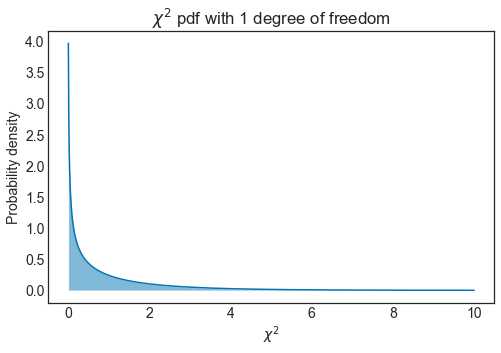

In [37]:
xarr = np.linspace(0, 10, 1000)
y_chi2 = scipy.stats.chi2.pdf(xarr, df=1, loc=0, scale=1)

fig = plt.figure(figsize=(8,5))
plt.plot(xarr, y_chi2)
plt.fill_between(xarr, y_chi2, alpha=0.5)
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability density')
plt.title(r'$\chi^2$ pdf with 1 degree of freedom')
fig.savefig('Problem1');

## Problem 2

For data and a probability distribution function with 4 fit parameters which satisfies Wilks theorem, what is the value of the 2*ln-likelihood difference ( ) that should be used to construct the 77.9% confidence interval from the best-fit point?

**Scipy.stats.chi2.ppf** (percent point function) takes the area (confidence limit, here 77.9%) and degress of freedom as input and returns the x value where this area is withint (when integrating from -inf to x). Scipy.stats.chi2.isf integrates from inf to x. 

In [38]:
twodelta_llh_value = scipy.stats.chi2.ppf(0.779, df=4) 
print('To construct a 77.9% confidence interval for a function with 4 parameters, one should use a value at',
      round(twodelta_llh_value,3), 'of the 2ln-lh difference.')

To construct a 77.9% confidence interval for a function with 4 parameters, one should use a value at 5.721 of the 2ln-lh difference.


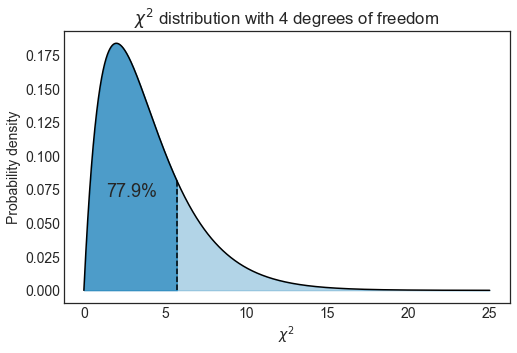

In [39]:
xarr_1 = np.linspace(0, twodelta_llh_value, 1000)
y_chi2_1 = scipy.stats.chi2.pdf(xarr_1, df=4, loc=0, scale=1)

xarr_2 = np.linspace(twodelta_llh_value, 25, 1000)
y_chi2_2 = scipy.stats.chi2.pdf(xarr_2, df=4, loc=0, scale=1)

fig = plt.figure(figsize=(8,5))
plt.plot(xarr_1, y_chi2_1, color='black')
plt.plot(xarr_2, y_chi2_2, color='black')
plt.fill_between(xarr_1, y_chi2_1, color=color[0], alpha=0.7)
plt.fill_between(xarr_2, y_chi2_2, color=color[0], alpha=0.3)
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability density')
plt.title(r'$\chi^2$ distribution with 4 degrees of freedom')
plt.vlines(twodelta_llh_value, min(y_chi2_2), max(y_chi2_2), color = 'black', ls='--')
plt.text(1.4, 0.07, '77.9%', fontsize=18)
plt.savefig('Problem2');

## Problem 3a

Plot the shark length data as a histogram. As a separate 
plot, show the density estimate from a Kernel Density 
Estimation method where: 

**Parsing data**

In [40]:
shark_data = np.genfromtxt('WhiteSharkLength.txt', skip_header=2)

**Defining the kde**

Specifying the banwidth to 25 cm: choose bw_method to be the scalar divided by the std. 

In [41]:
kde = stats.gaussian_kde(shark_data, bw_method=25/shark_data.std(ddof=1))
data_space = np.linspace(0, 750, 75001) 
evaluated_kde = kde.evaluate(data_space)

**Plotting result**

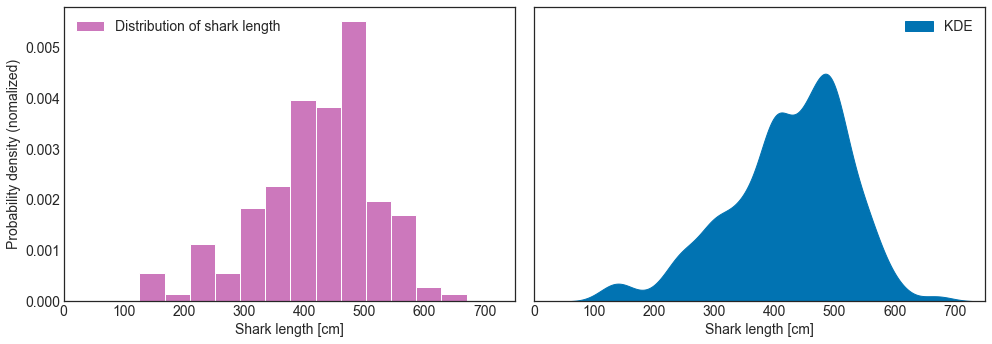

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)
aas.plot_hist(shark_data, min(shark_data), max(shark_data), 13, ax1, xlabel='Shark length [cm]', 
              ylabel='Probability density (nomalized)', histlabel='Distribution of shark length', 
              d_xy = [0.80, 0.20], color=color[4])
ax1.set_xlim(0,750)
#ax2.plot(data_space, evaluated_kde, '-', color='black') 
ax2.fill_between(data_space, evaluated_kde, color=color[0], label = 'KDE')
ax2.set_xlabel('Shark length [cm]')
ax2.set_xlim(0,750)
ax2.legend()
fig.tight_layout()
fig.savefig('Problem3a_twoplots');

Using the constructed KDE what is the p-value of recording 
a White shark that is longer than 653 cm in length?

In [43]:
def integrate(x, y, x_low_lim, x_high_lim):
    'Integrates pdf from low limit to high limit'
    idx_low_lim, idx_high_lim = np.searchsorted(x, [x_low_lim, x_high_lim])
    integral = np.trapz(y[idx_low_lim:idx_high_lim+1], x[idx_low_lim:idx_high_lim+1])
    return integral

In [44]:
p = integrate(data_space, evaluated_kde, 653.001, data_space.max())
print('The probability of getitng a shark that is longer than 653 cm is', p)

The probability of getitng a shark that is longer than 653 cm is 0.00469201818632193


## Problem 3b

Including the previous KDE from Problem 3a and the new length 
probability equations—and assuming that the Pacific Northwest 
ocean White shark population is 50:50 for female:male—what is the 
probability that an observed White shark of weight 763 kg in the 
Pacific Northwest ocean will have a length greater than 337 cm?

Weights for the female and male sharks; dependent on length and mass.

In [45]:
# length probability equations for female and male sharks - already normalized
def female_weight(L):
    return 1/(55*np.sqrt(2*np.pi))*np.exp(-(L-0.434*m)**2/(2*55**2))

def male_weight(L):
    return 1/(62*np.sqrt(2*np.pi))*np.exp(-(L-0.293*m)**2/(2*62**2))

# PRIOR: combind (weighted) weigth of female and male sharks (50:50) - already normalized
def prior(L):
    return (female_weight(L)+male_weight(L)) / 2 

# LIKELIHOOD: KDE
def likelihood(L):
    kde = stats.gaussian_kde(shark_data, bw_method=25/shark_data.std(ddof=1))
    evaluated_kde = kde.evaluate(L)
    return evaluated_kde

# POSTERIOR: prior * likelihood / normalization
def posterior(L):
    pos = prior(L)*likelihood(L)
    pos /= np.trapz(pos, L)
    return pos

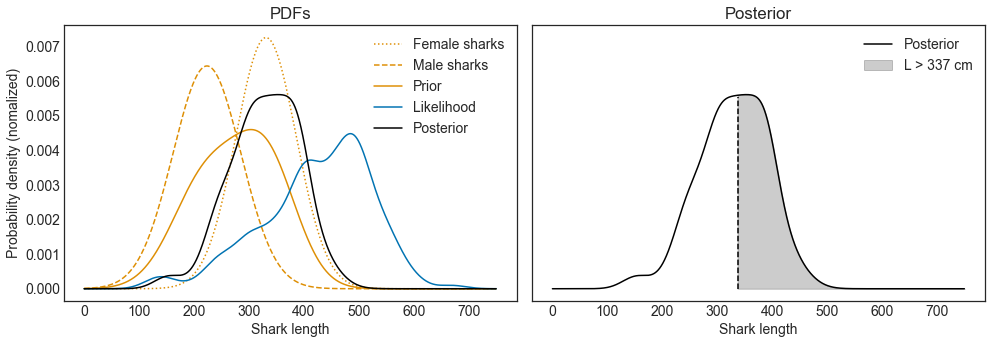

In [46]:
# probability distributions of shark length given a mass
m = 763
pdf_female = female_weight(data_space)
pdf_male = male_weight(data_space)
pri = prior(data_space)
llh = likelihood(data_space)
pos = posterior(data_space)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)
ax1.set_title('PDFs')
ax1.plot(data_space, pdf_female, label = 'Female sharks', color=color[1], ls='dotted')
ax1.plot(data_space, pdf_male, label = 'Male sharks', color=color[1], ls='dashed')
ax1.plot(data_space, pri, label = 'Prior', color=color[1])
ax1.plot(data_space, llh, '-', label = 'Likelihood', color=color[0])
ax1.plot(data_space, pos, '-', label = 'Posterior', color='black')
ax1.set_xlabel('Shark length')
ax1.set_ylabel('Probability density (nomalized)') # for W = 763 kg
ax1.legend()

ax2.set_title('Posterior')
ax2.plot(data_space, pos, '-', label = 'Posterior', color='black')
ax2.fill_between(data_space[33701:], pos[33701:], color='black', alpha=0.2, label='L > 337 cm')
ax2.vlines(337.01, 0, 0.00555, ls='dashed', color='black')
ax2.set_xlabel('Shark length')
ax2.legend()

fig.tight_layout()
fig.savefig('Problem3b');

In [47]:
p = integrate(data_space, pos, 337.01, data_space.max())
print('The probability of getting a shark that is longer than 337 cm is', p)

The probability of getting a shark that is longer than 337 cm is 0.47646000525754567


## Problem 3c

Repeat 3b, but now consider only mature sharks, where 
mature sharks are those with length > 201 cm. 

In [48]:
# Female and male weights need to be normalized again so integral equals 1 from 201 to inf
def female_weight_truncated(L):
    pdf = 1/(55*np.sqrt(2*np.pi))*np.exp(-(L-0.434*m)**2/(2*55**2)) 
    pdf = np.where((L >= 201), pdf, 0.) 
    pdf /= np.trapz(pdf, L)
    return pdf

def male_weight_truncated(L):
    pdf = 1/(62*np.sqrt(2*np.pi))*np.exp(-(L-0.293*m)**2/(2*62**2)) 
    pdf = np.where((L >= 201), pdf, 0.) 
    pdf /= np.trapz(pdf, L)
    return pdf

# PRIOR: combind (weighted) weigth of female and male sharks (50:50) 
# already normalized
def prior_trun(L):
    prior = (female_weight_truncated(L)+male_weight_truncated(L)) / 2 
    return prior

# LIKELIHOOD: KDE - needs to be normalized so integral equals 1 from 201 to inf
def likelihood_trun(L):
    kde = stats.gaussian_kde(shark_data, bw_method=25/shark_data.std(ddof=1))
    evaluated_kde = kde.evaluate(L)
    evaluated_kde = np.where((L >= 201), evaluated_kde, 0.) 
    evaluated_kde /= np.trapz(evaluated_kde, L)
    return evaluated_kde

# POSTERIOR: likelihood * prior / normalization
def posterior_trun(L):
    pos = prior_trun(L)*likelihood_trun(L)
    pos = np.where((L >= 201), pos, 0.) 
    pos /= np.trapz(pos, L)
    return pos

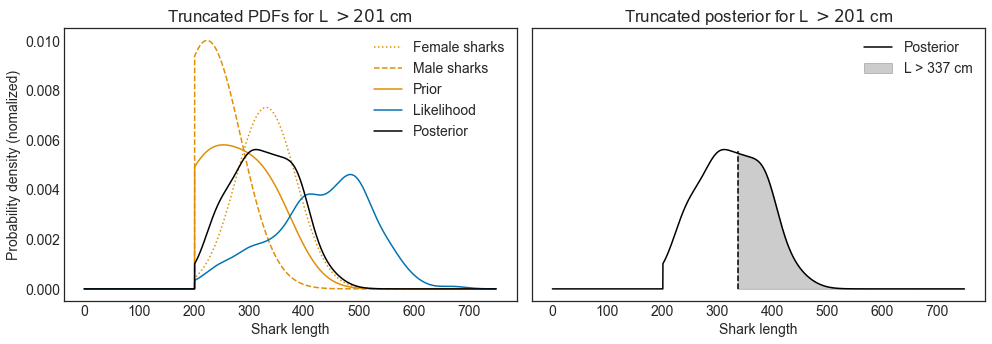

In [49]:
pdf_female_trun = female_weight_truncated(data_space)
pdf_male_trun = male_weight_truncated(data_space)
pri_trun = prior_trun(data_space)
llh_trun = likelihood_trun(data_space)
pos_trun = posterior_trun(data_space)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)
ax1.set_title('Truncated PDFs for L $> 201$ cm')
ax1.plot(data_space, pdf_female_trun, label = 'Female sharks', color=color[1], ls='dotted')
ax1.plot(data_space, pdf_male_trun, label = 'Male sharks', color=color[1], ls='dashed')
ax1.plot(data_space, pri_trun, label = 'Prior', color=color[1])
ax1.plot(data_space, llh_trun, '-', label = 'Likelihood', color=color[0])
ax1.plot(data_space, pos_trun, '-', label = 'Posterior', color='black')
ax1.set_xlabel('Shark length')
ax1.set_ylabel('Probability density (nomalized)') # for W = 763 kg
ax1.legend()

ax2.set_title('Truncated posterior for L $> 201$ cm')
ax2.plot(data_space, pos_trun, '-', label = 'Posterior', color='black')
ax2.fill_between(data_space[33701:], pos_trun[33701:], color='black', alpha=0.2, label='L > 337 cm')
ax2.vlines(337.01, 0, 0.00555, ls='dashed', color='black')
ax2.set_xlabel('Shark length')
ax2.legend()

fig.tight_layout()

fig.savefig('Problem3c');

In [50]:
p = integrate(data_space, pos_trun, 337.01, data_space.max())
print('The probability of getitng a shark that is longer than 337 cm is', p)

The probability of getitng a shark that is longer than 337 cm is 0.44704360562698814


## Problem 4a

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### Parsing data

In [52]:
train = np.genfromtxt('Set3_Prob4_TrainData.csv', skip_header=1, delimiter=',')[:,1:-1]
train_class = np.genfromtxt('Set3_Prob4_trainData.csv', skip_header=1, delimiter=',')[:,-1]

test = np.genfromtxt('Set3_Prob4_TestData.csv', skip_header=1, delimiter=',')[:,1:-1]
test_class = np.genfromtxt('Set3_Prob4_TestData.csv', skip_header=1, delimiter=',')[:,-1]

### Checking size of each class is in training and testing data

In [53]:
N_1_train = int(sum(train_class))
N_0_train = int(len(train_class)-N_1_train)

N_1_test = int(sum(test_class))
N_0_test = int(len(test_class)-N_1_test)

print('Training data \nRevenue == 1:', N_1_train, '\nRevenue == 0:', N_0_train)
print('\nTesting data \nRevenue == 1:', N_1_test, '\nRevenue == 0:', N_0_test)

Training data 
Revenue == 1: 454 
Revenue == 0: 2546

Testing data 
Revenue == 1: 480 
Revenue == 0: 2520


### Since the sizes are very different, we remove some data from the class with the largest size so the decision tree is not biased

In [55]:
N_drop = N_0_train-N_1_train

idxs = np.where(train_class == 0)[0]
idxs_drop = np.random.choice(idxs, size=N_drop, replace=False)
train_trun = np.delete(train, idxs_drop, axis=0)
train_class_trun = np.delete(train_class, idxs_drop, axis=0)

### Train the decision tree on the truncated training data and testing it on all the testing data

In [80]:
# Training data
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, splitter='best'), algorithm="SAMME", n_estimators=200)
dlf = clf.fit(train_trun, train_class_trun)


# Testing data
twoclass_output = clf.decision_function(test)

### Changing the output for confusion matrix

In [75]:
twoclass_output_cm = twoclass_output.copy()
twoclass_output_cm[twoclass_output_cm<0]=0
twoclass_output_cm[twoclass_output_cm>0]=1

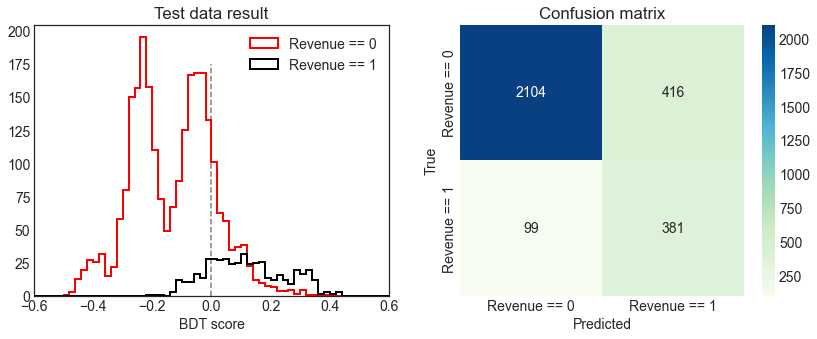

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
range = (-1, 1)

hist0 = ax1.hist(twoclass_output[test_class==0], bins=100, range=range, label='Revenue == 0', histtype='step', linewidth=2, color='red')
hist1 = ax1.hist(twoclass_output[test_class==1], bins=100, range=range, label='Revenue == 1', histtype='step', linewidth=2, color='black')
ax1.set_xlabel('BDT score')
ax1.legend()
ax1.set_xlim(-0.6, 0.6)
ax1.vlines(0, 0, 175, color='grey', ls='dashed')
ax1.set_title('Test data result')

matrix_conf = confusion_matrix(test_class, twoclass_output_cm)
sns_plot = sns.heatmap(
    matrix_conf,
    annot=True,
    cmap='GnBu',
    xticklabels=['Revenue == 0', 'Revenue == 1'],
    yticklabels=['Revenue == 0', 'Revenue == 1'],
    fmt="d",
    annot_kws={"fontsize": 14}
)
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title("Confusion matrix")

#ax2.text(1.10, 0.35, r'TP', fontsize=18, transform=ax.transAxes, verticalalignment='top', color = 'darkblue')
#ax2.text(0.95, 0.35, r'FN', fontsize=18, transform=ax.transAxes, verticalalignment='top', color = 'darkblue')
#ax2.text(0.95, 0.50, r'TN', fontsize=18, transform=ax.transAxes, verticalalignment='top', color = 'white')
#ax2.text(1.10, 0.50, r'FP', fontsize=18, transform=ax.transAxes, verticalalignment='top', color = 'darkblue')

fig.savefig('Problem4a')

In [77]:
tn, fp, fn, tp = matrix_conf.ravel()
print('True negative', tn, 
      '\nFalse positive', fp, 
      '\nFalse negative',fn,
      '\nTrue positive', tp)

True negative 2104 
False positive 416 
False negative 99 
True positive 381


In [78]:
def TPR(tp, fn):
    'True positive rate'
    return tp/(tp+fn)

def FPR(fp, tn):
    'True positive rate'
    return fp/(fp+tn)

In [79]:
print('True positive rate =', TPR(tp, fn))
print('False positive rate =', FPR(fp, tn))

True positive rate = 0.79375
False positive rate = 0.16507936507936508


In [62]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=test_class, y_pred=twoclass_output_cm)

0.828

## Exercise 4b - ROC curves

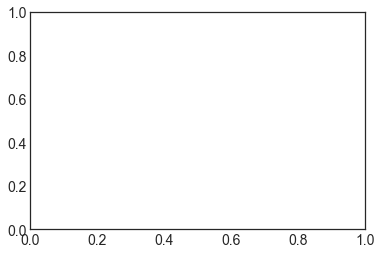

In [26]:
fig, ax = plt.subplots()

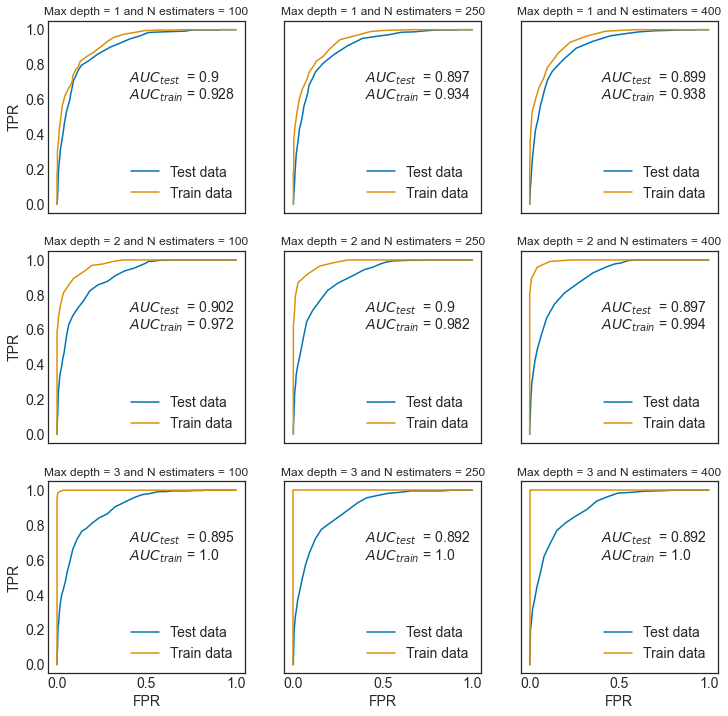

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [27]:
depth = [1,2,3]
n_est = [100, 250, 400]

fig, axes = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)
for idxi, i in enumerate(depth):
    for idxj, j in enumerate(n_est):
        clf_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i, splitter='best'), algorithm="SAMME", n_estimators=j)
        plt.figure()
        # TESTING DATA
        clf_ = clf_.fit(train_trun, train_class_trun)
        twoclass_output = clf_.decision_function(test)
        hist0 = ax.hist(twoclass_output[test_class==0], bins=100, range=range)
        hist1 = ax.hist(twoclass_output[test_class==1], bins=100, range=range)
        FPR, TPR, AUC = aas.calc_ROC(hist1, hist0) # first histogram has to be signal
        axes[idxi][idxj].plot(FPR, TPR, label = f'Test data')
        axes[idxi][idxj].text(0.4, 0.7, r'$AUC_{test}$  = %s' %round(AUC,3))
        
        # TRAINING DATA
        twoclass_output_train = clf_.decision_function(train_trun)
        hist0_train = ax.hist(twoclass_output_train[train_class_trun==0], bins=100, range=range)
        hist1_train = ax.hist(twoclass_output_train[train_class_trun==1], bins=100, range=range)
        FPR_train, TPR_train, AUC_train = aas.calc_ROC(hist1_train, hist0_train) # first histogram has to be signal
        axes[idxi][idxj].plot(FPR_train, TPR_train, label = f'Train data')
        axes[idxi][idxj].text(0.4, 0.6, r'$AUC_{train}$ = %s' %round(AUC_train,3))
        axes[idxi][idxj].set_title(f'Max depth = {i} and N estimaters = {j}', fontsize=12)
        axes[idxi][idxj].legend()
        
        axes[idxi][0].set_ylabel('TPR')
        axes[2][idxj].set_xlabel('FPR')
        
fig.savefig('Problem4b')

## Exercise 4c

**Using the same setting(s) as developed in Problem 4a, run
the classifier over all the entries in the blind sample**

In [28]:
# Blind data
blinddata = np.genfromtxt('Set3_Prob4_BlindData.csv', delimiter=',', skip_header=1)[:,1:] 
twoclass_output_blind = clf.decision_function(blinddata)
twoclass_output_blind[twoclass_output_blind>0]=1
twoclass_output_blind[twoclass_output_blind<0]=0

In [29]:
IDs = np.genfromtxt('Set3_Prob4_BlindData.csv', delimiter=',', skip_header=1)[:,0] 
IDs_true = IDs[twoclass_output_blind == 1]
IDs_false = IDs[twoclass_output_blind == 0]

In [30]:
print('Blind data \nRevenue == 1:', int(len(IDs_true)), '\nRevenue == 0:', int(len(IDs_false)))

Blind data 
Revenue == 1: 856 
Revenue == 0: 2144


In [31]:
np.savetxt('Wilson.Problem4.RevenueTrue.txt', IDs_true)
np.savetxt('Wilson.Problem4.RevenueFalse.txt', IDs_false)